In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
data = loaddata(simulation_names)

inputHistories = np.array([element[0] for element in data])
mass_presentsfr = np.array([element[1] for element in data])
labels = np.array([element[2] for element in data])

for i in range(len(labels)):
    if labels[i] == 'Eagle':
        labels[i] = 0
    elif labels[i] == 'Illustris':
        labels[i] = 1
    elif labels[i] == 'IllustrisTNG':
        labels[i] = 2
    elif labels[i] == 'Mufasa':
        labels[i] = 3
    elif labels[i] == 'Simba':
        labels[i] = 4
    elif labels[i] == 'SC-Sam':
        labels[i] = 5
    elif labels[i] == 'UniverseMachine':
        labels[i] = 6
    elif labels[i] == 'Fire-2':
        labels[i] = 7
    elif labels[i] == 'g14':
        labels[i] = 8
    elif labels[i] == 'Marvel_JL':
        labels[i] = 9
labels = np.array(labels).astype('float32')


filtered_inputHistories, filtered_mass_presentsfr, filtered_labels = filter_zeroes(inputHistories, mass_presentsfr, labels)

In [2]:
from LoadData import count_zeroes
count_zeroes(inputHistories, mass_presentsfr, labels)

Total number of galaxies: 63147
Number of galaxies with zero SFH in each simulation:
0.0 37
1.0 0
2.0 0
3.0 0
4.0 0
5.0 0
6.0 0
7.0 0
8.0 0
9.0 0
Total number of galaxies with zero SFH: 37


In [10]:
np.unique(filtered_labels, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32),
 array([ 7445, 19354, 12220,  1900,  1982, 12821,  7361,    14,     8,
            5]))

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_inputHistories, filtered_mass_presentsfr, test_size=0.2, random_state=42)

# Normalize the star formation histories
X_train = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_train]  # Normalize SFH
X_test = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_test]    # Normalize SFH

X_train = np.array(X_train)
X_test = np.array(X_test)

# Further split the training data into 80% (64%) training and 20% (16%) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

device = "cpu"
print(f"Using {device} device")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Using cpu device


**The first 100 SFHs:**

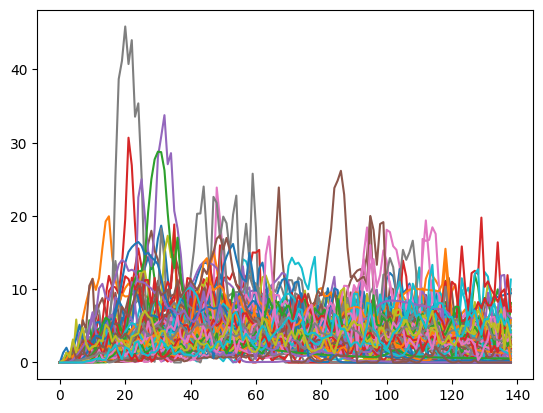

In [5]:
for i in range(100):
    plt.plot(X_train_tensor[i])

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the neural network
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)  
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)  
        self.pool = nn.MaxPool1d(2, 2)  
        self.fc1 = nn.Linear(16 * 7, 64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 12)
        
        # Decoder
        self.fc4 = nn.Linear(12, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 16 * 7)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2)
        
    def encoder(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))  
        x = x.view(-1, 16 * 7)  # Matching new dimensions after convolutions and pooling
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = self.fc3(x)
        return encoded

    def decoder(self, x):
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = x.view(-1, 16, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create the model instance
AE = ConvAutoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming regression task with MSE loss
optimizer = optim.Adam(AE.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

# Create a DataLoader for batch processing
dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [29]:
print(AE)

ConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=112, bias=True)
  (deconv1): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv3): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(2,))
  (deconv4): ConvTranspose1d(16, 1, kernel_size=(

In [18]:
# Training loop
num_epochs = 800
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for data in dataloader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = AE(inputs)
        curr_loss = criterion(outputs, inputs) # Comparing output to input for autoencoder
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    AE.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            val_inputs, _ = data
            val_outputs = AE(val_inputs)
            val_loss += criterion(val_outputs, val_inputs).item() # Comparing validation output and input
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
    # tell scheduler to consider updating learning rate
    scheduler.step()

print('Training complete')

Epoch [0/800], Training Loss: 9.4293, Val Loss: 5.0584
Epoch [10/800], Training Loss: 2.1115, Val Loss: 2.0809
Epoch [20/800], Training Loss: 1.9281, Val Loss: 1.9017
Epoch [30/800], Training Loss: 1.8652, Val Loss: 1.8770
Epoch [40/800], Training Loss: 1.7422, Val Loss: 1.7291
Epoch [50/800], Training Loss: 1.6532, Val Loss: 1.6420
Epoch [60/800], Training Loss: 1.6125, Val Loss: 1.6552
Epoch [70/800], Training Loss: 1.5924, Val Loss: 1.6028
Epoch [80/800], Training Loss: 1.5802, Val Loss: 1.6203
Epoch [90/800], Training Loss: 1.5682, Val Loss: 1.5956
Epoch [100/800], Training Loss: 1.5602, Val Loss: 1.5834
Epoch [110/800], Training Loss: 1.5347, Val Loss: 1.5403
Epoch [120/800], Training Loss: 1.4944, Val Loss: 1.5113
Epoch [130/800], Training Loss: 1.4807, Val Loss: 1.4928
Epoch [140/800], Training Loss: 1.4761, Val Loss: 1.4978
Epoch [150/800], Training Loss: 1.4664, Val Loss: 1.5095
Epoch [160/800], Training Loss: 1.4681, Val Loss: 1.4638
Epoch [170/800], Training Loss: 1.4525, Va

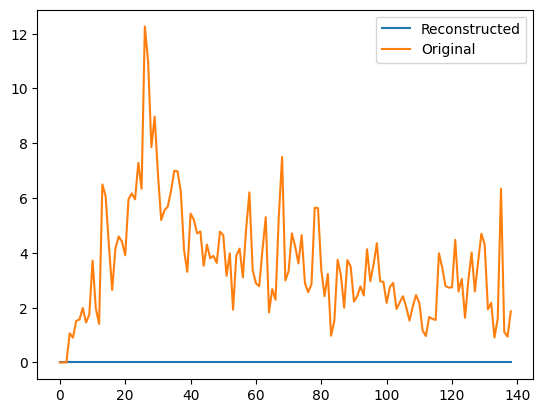

In [26]:
i = 42
plt.plot(AE(X_val_tensor[i].unsqueeze(0).unsqueeze(0))[0][0].detach().numpy())
plt.plot(X_val_tensor[i].unsqueeze(0).unsqueeze(0)[0][0].detach().numpy())
plt.legend(['Reconstructed', 'Original'])

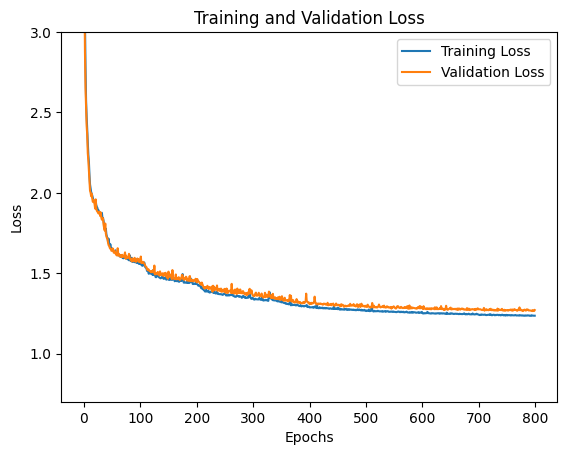

In [19]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.7,3)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

np.save('AE Losses/12lat1.268loss.npy', val_losses)

In [33]:
generated_SFHs = AE(X_test_tensor.unsqueeze(1))
real_SFHs = X_test_tensor.unsqueeze(1)

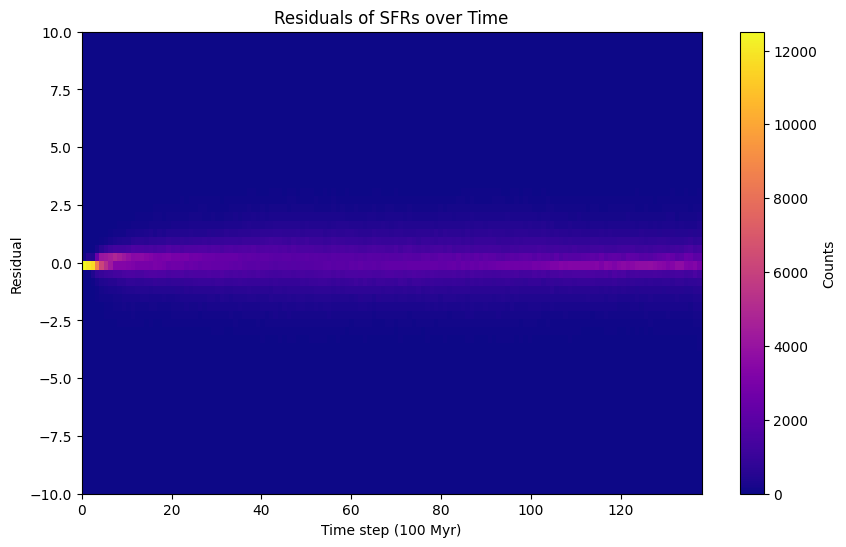

In [11]:
# Calculate residuals
residuals = (generated_SFHs - real_SFHs).detach().numpy().squeeze()

# Create time axis
time_axis = np.tile(np.arange(residuals.shape[1]), residuals.shape[0])

# Flatten the residuals
residuals_flat = residuals.flatten()

# Create a 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(time_axis, residuals_flat, bins=[139, 200], cmap='plasma')
plt.ylim(-10,10)
plt.colorbar(label='Counts')
plt.xlabel('Time step (100 Myr)')
plt.ylabel('Residual')
plt.title('Residuals of SFRs over Time')
plt.show()

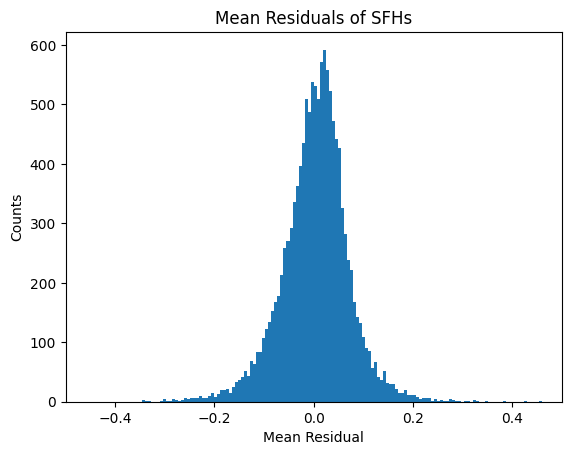

In [12]:
plt.hist([np.mean(residual) for residual in residuals], bins=150)
plt.xlabel('Mean Residual')
plt.ylabel('Counts')
plt.title('Mean Residuals of SFHs')
plt.xlim(-0.5, 0.5)
plt.show()

In [9]:
AE = torch.load('AE Models/16lat1.139loss.pth')
print(AE)

ConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=112, bias=True)
  (deconv1): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv3): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(2,))
  (deconv4): ConvTranspose1d(16, 1, kernel_size=(

In [25]:
# joining together the training, testing and validation sets individually
all_mass_presentsfr = torch.cat((y_train_tensor, y_test_tensor, y_val_tensor), 0)
all_data_tensor = torch.cat((X_train_tensor, X_test_tensor, X_val_tensor), 0)
latent_space = AE.encoder(all_data_tensor.unsqueeze(1)).detach().numpy()
np.save('Latent data/SFHdata.npy', all_data_tensor.numpy())
np.save('Latent data/latentdata.npy', latent_space)
np.save('Latent data/masspresentsfr.npy', all_mass_presentsfr.numpy())


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel JL']

for x in range(16):
    for y in range(16):
        if x == y:
            continue
        plt.scatter(latent_space.T[x], latent_space.T[y], c=all_labels_tensor, cmap='Spectral', s=0.05)
        plt.gca().set_aspect('equal', 'datalim')

        # Create a colorbar
        cbar = plt.colorbar(boundaries=np.arange(11)-0.5, ticks=np.arange(10))

        # Set the colorbar labels
        cbar.ax.set_yticklabels(labels)

        plt.xlabel(f'Latent Dimension {x}')
        plt.ylabel(f'Latent Dimension {y}')
        plt.show()

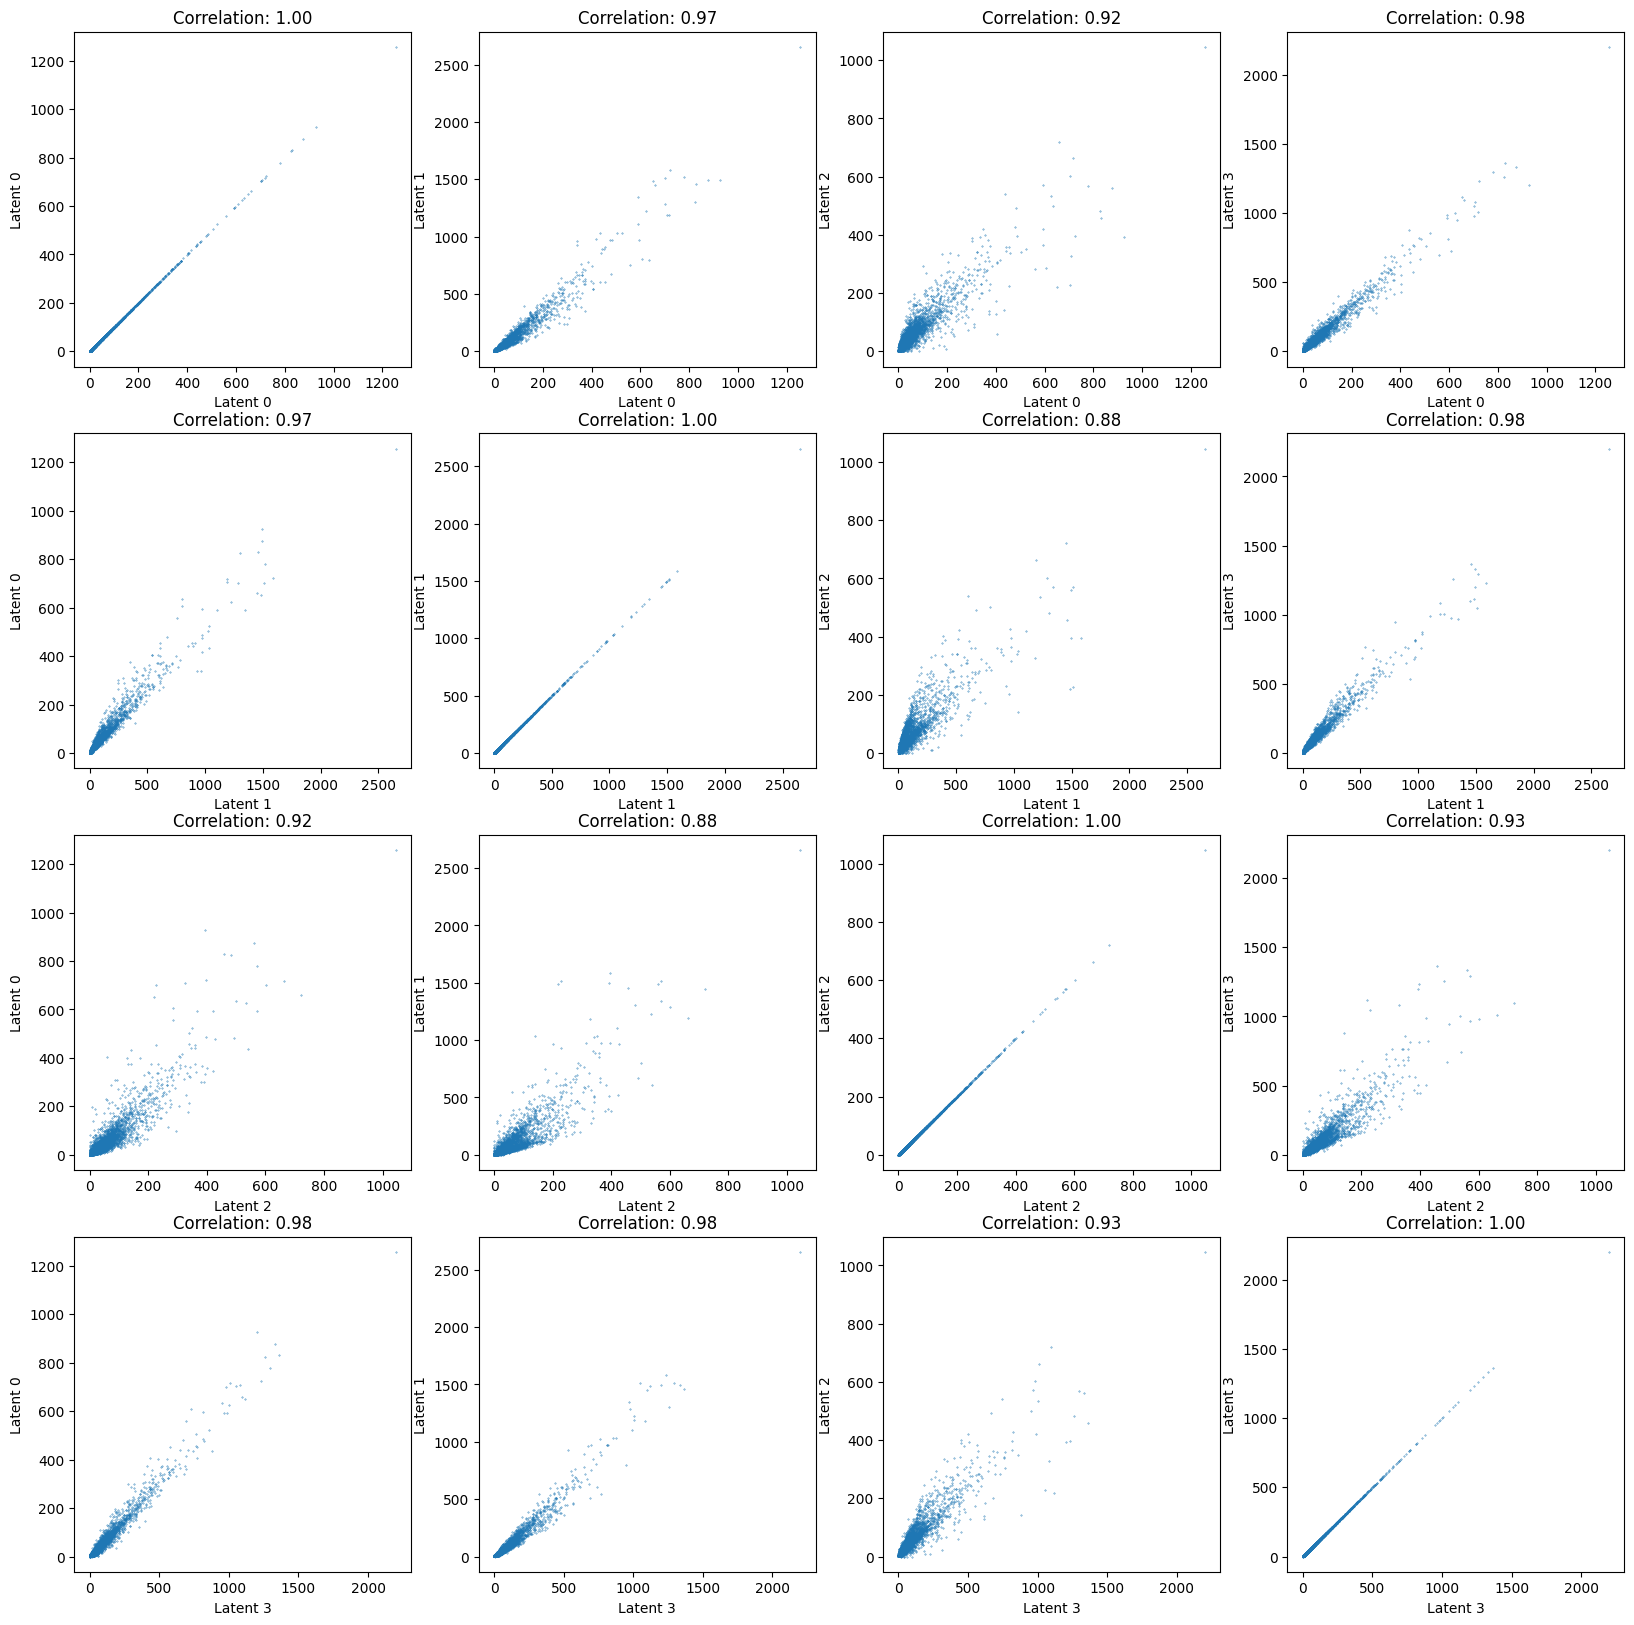

In [235]:
# Creating 16 correlation plots between all 4 latent parameters, showing the coeffcients of correlation for each pair
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        axs[i, j].scatter(latent_space.T[i], latent_space.T[j], s=0.1, alpha=1)
        axs[i, j].set_title(f'Correlation: {np.corrcoef(latent_space.T[i], latent_space.T[j])[0, 1]:.2f}')
        axs[i, j].set_xlabel(f'Latent {i}')
        axs[i, j].set_ylabel(f'Latent {j}')

In [55]:
def interpolate_parameter_x(x, latent_space, n=10):
    '''
    Plotting the time series data with the decoder by interpolating n times between the 10th percentile and 90th percentile values of latent parameter
    #x, while setting all other parameters to their mean values.
    '''
    latent_space_mean = np.mean(latent_space, axis=0)
    for i in range(n):
        paramts = np.zeros(len(latent_space.T))
        for j in range(len(latent_space.T)):
            if j == x:
                paramts[j] = np.linspace(np.percentile(latent_space.T[j], [10])[0], np.percentile(latent_space.T[j], [90])[0], n)[i]
            else:
                paramts[j] = latent_space_mean[j]
        plt.plot(AE.decoder(torch.tensor(paramts, dtype=torch.float32).unsqueeze(0).unsqueeze(0))[0][0].detach().numpy())
            

In [27]:
latent_space[0]

array([10.743292 ,  6.396635 ,  0.       ,  3.708521 ,  0.       ,
        9.608013 ,  0.       ,  9.03813  , 13.542111 , 11.861317 ,
       18.521324 , 16.634575 , 10.697365 ,  9.8015   ,  5.8884077,
        0.       ,  0.       ,  7.3337884,  7.8601794, 10.154566 ],
      dtype=float32)

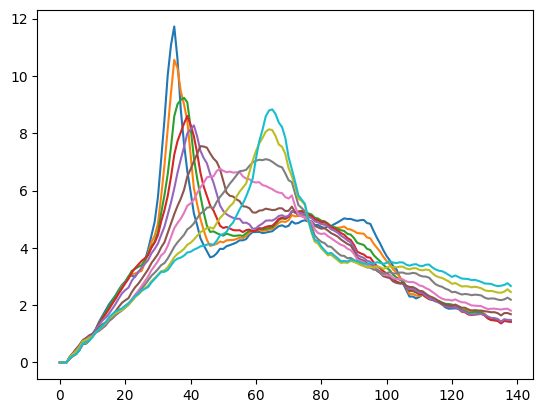

In [70]:
interpolate_parameter_x(3, latent_space, 10)

In [137]:
np.percentile(latent_space.T[1], [25])[0]

0.0

In [113]:
for i in range(int(latent_space.T[0].min()), int(latent_space.T[0].max()), 100):
    rest_of_params = [np.mean(latent_space.T[i]) for i in range(1, 16)]
    parameters = [i, *rest_of_params]
    plt.plot(AE.decoder(torch.tensor([i, *rest_of_params], dtype=torch.float32).unsqueeze(0).unsqueeze(0))[0][0].detach().numpy())

plt.plot(AE.decoder(torch.tensor([np.mean(latent_space.T[i]) for i in range(16)], dtype=torch.float32).unsqueeze(0).unsqueeze(0))[0][0].detach().numpy())

array([6.6122012e+00, 0.0000000e+00, 7.2604947e+00, 0.0000000e+00,
       9.0367699e+00, 5.8351188e+00, 6.3068647e+00, 1.0741932e+01,
       0.0000000e+00, 5.6602225e+00, 6.0648375e+00, 7.5914750e+00,
       8.3066292e+00, 6.5736423e+00, 9.0329876e+00, 1.4880614e-03],
      dtype=float32)

Text(0, 0.5, 'SFR')

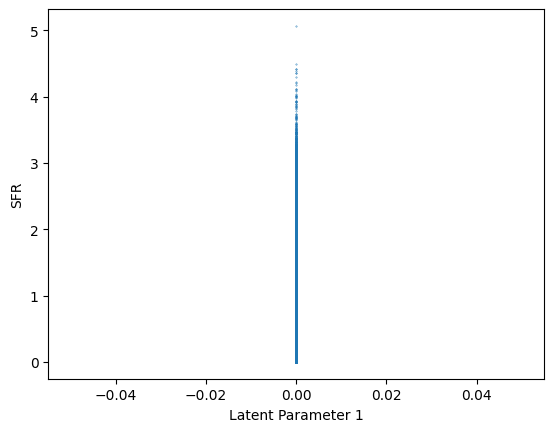

In [72]:
plt.scatter(latent_space.T[1], filtered_mass_presentsfr.T[1], s=0.1)
plt.xlabel('Latent Parameter 1')
plt.ylabel('SFR')

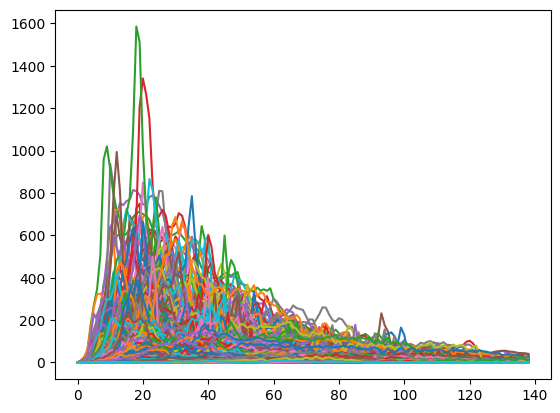

In [82]:
for i in range(len(X_train_tensor)):
    plt.plot(all_data_tensor[i])

In [65]:
import umap
reducer = umap.UMAP(n_components=2, n_neighbors=100)
embedding = reducer.fit_transform(latent_space)
embedding.shape

(63110, 2)

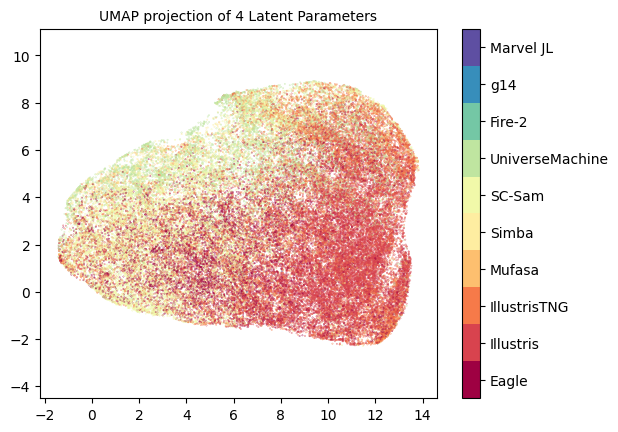

In [67]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel JL']

plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels_tensor, cmap='Spectral', s=0.05)
plt.gca().set_aspect('equal', 'datalim')

# Create a colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5, ticks=np.arange(10))

# Set the colorbar labels
cbar.ax.set_yticklabels(labels)

plt.title('UMAP projection of 4 Latent Parameters', fontsize=10)
plt.show()

In [20]:
torch.save(AE, 'AE Models/12lat1.268loss.pth')

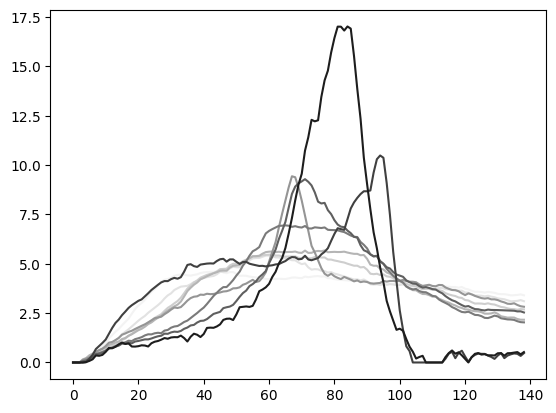

In [72]:
get_ah_from_umap(12, -2, 5, 7, embedding, latent_space) # Extracting SFH parameters from UMAP space to see interesting structures!

In [71]:
from scipy.spatial import distance

def get_ah_from_umap(x1, y1, x2, y2, embedding: np.ndarray, latent_space: np.ndarray, num_observations=10):
    """
    Takes num_observations evenly spaced points along the vector connecting the given UMAP coordinates and plots the corresponding SFHs
    of the closest points in the embedding to the interpolated points.
    (x1, y1) and (x2, y2).
    """
    # Interpolate between the two points
    x_range = np.linspace(x1, x2, num_observations)
    y_range = np.linspace(y1, y2, num_observations)
    
    point_coordinates = [[x_range[i], y_range[i]] for i in range(num_observations)]
    for pair in point_coordinates:
        distances = [distance.euclidean(pair, point) for point in embedding]
        closest_point = np.argmin(distances)
        closest_latent = latent_space[closest_point]
        closest_SFH = AE.decoder(torch.tensor(closest_latent).unsqueeze(0)).detach().numpy().squeeze()
        plt.plot(closest_SFH, color=plt.cm.Greys(point_coordinates.index(pair)/num_observations))

(0.0, 4.0)

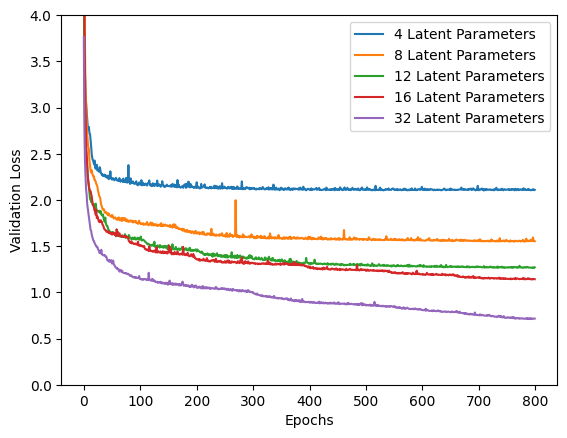

In [21]:
lat4loss2106 = np.load('AE Losses/4lat2.106loss.npy')
lat8loss1562 = np.load('AE Losses/8lat1.562loss.npy')
lat12loss1268 = np.load('AE Losses/12lat1.268loss.npy')
lat16loss1142 = np.load('AE Losses/16lat1.142loss.npy')
lat32loss0720 = np.load('AE Losses/32lat0.720loss.npy')
plt.plot(lat4loss2106, label='4 Latent Parameters')
plt.plot(lat8loss1562, label='8 Latent Parameters')
plt.plot(lat12loss1268, label='12 Latent Parameters')
plt.plot(lat16loss1142, label='16 Latent Parameters')
plt.plot(lat32loss0720, label='32 Latent Parameters')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.ylim(0,4)

(0.0, 4.5)

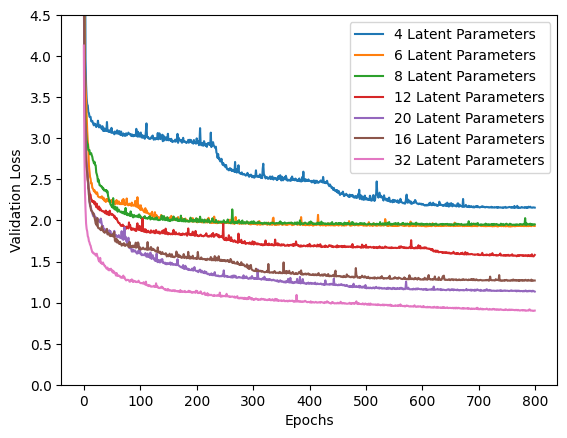

In [34]:
curve4lat2159loss = np.load('AE Losses/4lat2.159loss.npy')
curve6lat1935loss = np.load('AE Losses/6lat1.935loss.npy')
curve8lat1950loss = np.load('AE Losses/8lat1.950loss.npy')
curve16lat1269loss = np.load('AE Losses/16lat1.269loss.npy')
curve20lat1139loss = np.load('AE Losses/20lat1.139loss.npy')
curve32lat0917loss = np.load('AE Losses/32lat0.917loss.npy')
curve12lat1566loss = np.load('AE Losses/12lat1.566loss.npy')
plt.plot(curve4lat2159loss, label='4 Latent Parameters')
plt.plot(curve6lat1935loss, label='6 Latent Parameters')
plt.plot(curve8lat1950loss, label='8 Latent Parameters')
plt.plot(curve12lat1566loss, label='12 Latent Parameters')
plt.plot(curve20lat1139loss, label='20 Latent Parameters')
plt.plot(curve16lat1269loss, label='16 Latent Parameters')
plt.plot(curve32lat0917loss, label='32 Latent Parameters')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.ylim(0, 4.5)

In [15]:
curve8lat2145loss = np.load('AE Losses/24lat2.086loss.npy')
curve8lat2145loss

array([4.55858629, 3.48558221, 3.22299398, 2.99113375, 2.69574208,
       2.54922715, 2.42074293, 2.32247848, 2.26312099, 2.22001802,
       2.18153422, 2.16695169, 2.11950847, 2.08595188, 2.00639537,
       2.00268203, 1.9742842 , 1.96778902, 1.94132293, 1.93859557,
       1.95587869, 1.9257663 , 1.92856716, 1.89743826, 1.90355601,
       1.88964509, 1.87749946, 1.87648725, 1.91368362, 1.86664485,
       1.87277296, 1.88198848, 1.86182841, 1.85994223, 1.84179662,
       1.81661338, 1.82144128, 1.79532476, 1.76725701, 1.74824185,
       1.75352033, 1.76609588, 1.73972307, 1.72522608, 1.73782385,
       1.75726363, 1.74269291, 1.73344814, 1.71858226, 1.70695202,
       1.74706817, 1.79274215, 1.72679144, 1.70614808, 1.70494556,
       1.69319069, 1.69299133, 1.70498994, 1.68572131, 1.69219905,
       1.72111359, 1.66199239, 1.69562064, 1.6413895 , 1.62189742,
       1.61313133, 1.5992507 , 1.62859815, 1.57081937, 1.56490429,
       1.55387493, 1.5526608 , 1.53440948, 1.53423748, 1.53563